In [1]:
sentences = ["Kage is Teacher", "Mazong is Boss", 
             "Niuzong is Boss", "Xiaobing is Student",
             "Xiaoxue is Student"]
words = ' '.join(sentences).split()
word_list = list(set(words))
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list)
print("词汇表：", word_list)
print("词汇到索引的字典", word_to_idx)
print("索引到词汇的字典", idx_to_word)
print("词汇表大小：", voc_size)

词汇表： ['Niuzong', 'Mazong', 'Xiaobing', 'Kage', 'Teacher', 'Boss', 'Xiaoxue', 'Student', 'is']
词汇到索引的字典 {'Niuzong': 0, 'Mazong': 1, 'Xiaobing': 2, 'Kage': 3, 'Teacher': 4, 'Boss': 5, 'Xiaoxue': 6, 'Student': 7, 'is': 8}
索引到词汇的字典 {0: 'Niuzong', 1: 'Mazong', 2: 'Xiaobing', 3: 'Kage', 4: 'Teacher', 5: 'Boss', 6: 'Xiaoxue', 7: 'Student', 8: 'is'}
词汇表大小： 9


In [3]:
#生成cbow训练样本
def create_cbow_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            context_words = sentence[max(idx-window_size, 0):idx] + sentence[idx+1: min(idx+window_size, len(sentence))]
        data.append((word, context_words))
    return data
cbow_data = create_cbow_dataset(sentences)
print("cbow_data", cbow_data)

cbow_data [('Teacher', ['Kage', 'is']), ('Boss', ['Mazong', 'is']), ('Boss', ['Niuzong', 'is']), ('Student', ['Xiaobing', 'is']), ('Student', ['Xiaoxue', 'is'])]


In [6]:
import torch
def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(voc_size)
    tensor[word_to_idx[word]] = 1
    return tensor
word_example="Teacher"
print("word_example", word_example)
print("one_hot_encoding", one_hot_encoding(word_example, word_to_idx))
print("CBOW data:", [(one_hot_encoding(c, word_to_idx), word_to_idx[target]) 
                          for target, context in cbow_data[:3]
                          for c in context])

word_example Teacher
one_hot_encoding tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.])
CBOW data: [(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 4), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 4), (tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 5), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 5), (tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 5), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 5)]


In [7]:
#define cbow class
import torch.nn as nn
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)
    def forward(self, x):
        embedding = self.input_to_hidden(x)
        hidden = torch.mean(embedding, dim=0)
        output = self.hidden_to_output(hidden.unsqueeze(0))
        return output
embedding_size = 5
model = CBOW(voc_size, embedding_size)
print(model)

CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=5, bias=False)
  (hidden_to_output): Linear(in_features=5, out_features=9, bias=False)
)


Epoch: 100/1000, Loss: 0.0015
Epoch: 200/1000, Loss: 0.0006
Epoch: 300/1000, Loss: 0.0003
Epoch: 400/1000, Loss: 0.0002
Epoch: 500/1000, Loss: 0.0001
Epoch: 600/1000, Loss: 0.0001
Epoch: 700/1000, Loss: 0.0001
Epoch: 800/1000, Loss: 0.0000
Epoch: 900/1000, Loss: 0.0000
Epoch: 1000/1000, Loss: 0.0000


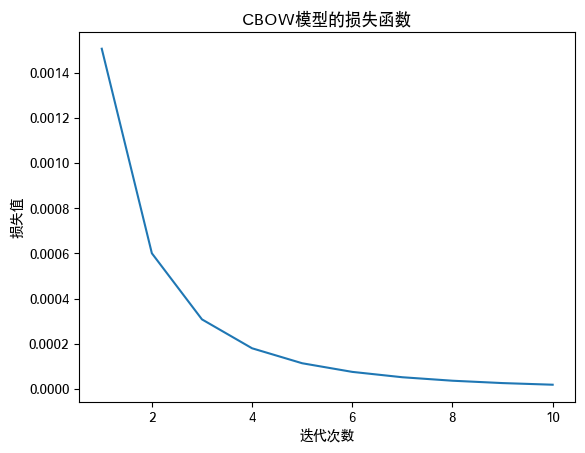

In [12]:
#训练CBOW模型
learning_rate = 0.001
epochs = 1000
criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    total_loss = 0
    for target, context in cbow_data:
        model.zero_grad()
        X = torch.stack([one_hot_encoding(c, word_to_idx) for c in context])
        y_true = torch.tensor([word_to_idx[target]])
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {total_loss/len(cbow_data):.4f}')
        losses.append(total_loss/len(cbow_data))
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Hei']
plt.rcParams['font.sans-serif'] = ['Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(1, epochs//100 + 1), losses)
plt.title('CBOW模型的损失函数')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()